In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import imageio as iio
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
from numba import cuda  # https://stackoverflow.com/a/52354865/6476994
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import csv
import re

In [2]:
# allows all images to be displayed at once (else only displays the last call to plt.imshow())
# https://stackoverflow.com/a/41210974
def displayImage(image, caption = None, colour = None) -> None:
    plt.figure()
    if(colour != None):
        plt.imshow(image, cmap=colour)
    else:
        plt.imshow(image)
        
    if(caption != None):
        # display caption below picture (https://stackoverflow.com/a/51486361)
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [3]:
# free up GPU
cuda.select_device(0)
cuda.close()

In [4]:
# mnist = tf.keras.datasets.mnist
# (training_images, training_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
# get the all original output filenames
def readInImages(datasetName):
    print("reading in images for dataset: {}".format(datasetName))
    image_list = []
    imgRegExp = re.compile(r'.*[.](JPG)$')
    # https://stackoverflow.com/a/3207973
    all_image_filenames = next(os.walk('data/{}'.format(datasetName)),
                         (None, None, []))[2]  # [] if no file
    # filter out file names that are not JPEGs
    all_image_filenames = [i for i in all_image_filenames if imgRegExp.match(i)]
    # walk() outputs unordered, so we need to sort
    all_image_filenames.sort()
    # print("all_image_filenames: {}".format(all_image_filenames))
    print("all_image_filenames length: {}".format(len(all_image_filenames)))
    for fn in all_image_filenames:
        # im = Image.open('data/{}/{}'.format(datasetName, fn))
        im = cv2.imread('data/{}/{}'.format(datasetName, fn))
        # resize the image to conserve memory
        im = cv2.resize(im, (480, 270), interpolation=cv2.INTER_CUBIC)
        # im = cv2.resize(im, (240, 135), interpolation=cv2.INTER_CUBIC)
        image_list.append(np.asarray(im))
    
    print("done current dataset")
    return image_list

all_images = []
# dataset_names = ["BB01", "BB02", "BB03", "BB04", "BB05", "BB06", "BB07", "BB08", "BB09", "BB10"]
dataset_names = ["BB04", "BB06"]
for fn in dataset_names:    
    all_images = [*all_images, *readInImages(fn)]
    
# convert list of numpy arrays to numpy array of numpy arrays
# https://stackoverflow.com/a/27516930/6476994
all_images = np.stack(all_images, axis = 0)

print("done stacking")

reading in images for dataset: BB04
all_image_filenames length: 999
done current dataset
reading in images for dataset: BB06
all_image_filenames length: 1137
done current dataset
done stacking


all_images_len: 2136
training_images length: 1708
training_images shape: (1708, 270, 480, 3)
test_images length: 427
test_images shape: (427, 270, 480, 3)


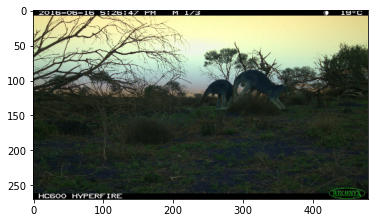

In [6]:
displayImage(all_images[0])
print("all_images_len: {}".format(len(all_images)))

training_images = all_images[0:1708]
print("training_images length: {}".format(len(training_images)))
print("training_images shape: {}".format(training_images.shape))
test_images = all_images[1709:2137]
print("test_images length: {}".format(len(test_images)))
print("test_images shape: {}".format(test_images.shape))

In [7]:
# labels (using dataset's CSV file)

def readInAnnotations(datasetName):
    labelList = []
    # https://realpython.com/python-csv/#reading-csv-files-with-csv
    with open('data/{}/{}.csv'.format(datasetName, datasetName)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            # print("row: {}".format(row))
            # first row always contains this string, so ignore it
            if "RECONYX - MapView Professional" in row:
                continue
            if line_count == 0:
                # print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                # print("Image Name: {}. Hit List: {}".format(row[0], row[22].replace("\n", ", ")))
                # FIXME handle when hitlist contains more than one item (e.g., BB06 IMG_512 has 'kangaroo' and 'empty photo')
                hit_list = row[22]
                if hit_list == '':
                    labelList.append("Empty photo")
                else:
                    labelList.append(hit_list.replace("\n", ", "))
                line_count += 1
    # print("returning labelList (length: {}): {}".format(len(labelList), labelList))
    # print("returning labelList of length: {}".format(len(labelList)))
    return labelList

all_image_labels = []
# dataset_names = ["BB01", "BB02", "BB03", "BB04", "BB05", "BB06", "BB07", "BB08", "BB09", "BB10"]
dataset_names = ["BB04", "BB06"]
for fn in dataset_names:
    all_image_labels = [*all_image_labels, *readInAnnotations(fn)]

# print("all_image_labels: {}".format(all_image_labels))

classes = set(all_image_labels)
print("classes (length={}): {}".format(len(classes), classes))
              
training_labels = all_image_labels[0:1708]
test_labels = all_image_labels[1709:2137]

# integer-encode labels so they can be one-hot-encoded
# https://stackoverflow.com/a/56227965/6476994
label_encoder = LabelEncoder()
training_labels = np.array(training_labels)
training_labels = label_encoder.fit_transform(training_labels)
test_labels = np.array(test_labels)
test_labels = label_encoder.fit_transform(test_labels)

classes (length=8): {'Fox', 'Kangaroo, Empty photo', 'Empty photo', 'Emu', 'Kangaroo', 'Cat', 'Other', 'Human Presense/Deployment'}


In [8]:
print("training_labels length: {}".format(len(training_labels)))
print("training_labels shape: {}".format(training_labels.shape))

print("test_labels length: {}".format(len(test_labels)))
print("test_labels shape: {}".format(test_labels.shape))

training_labels length: 1708
training_labels shape: (1708,)
test_labels length: 427
test_labels shape: (427,)


## Train the model

In [9]:
# training_images = tf.map_fn(lambda i: tf.stack([i]*3, axis=-1), training_images).numpy()
# test_images = tf.map_fn(lambda i: tf.stack([i]*3, axis=-1), test_images).numpy()

training_images = tf.image.resize(training_images, [270, 480]).numpy()
test_images = tf.image.resize(test_images, [270, 480]).numpy()

training_images = training_images.reshape(1708, 270, 480, 3)
training_images = training_images / 255.0
test_images = test_images.reshape(427, 270, 480, 3)
test_images = test_images / 255.0

training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=len(classes))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(classes))

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

model = tf.keras.models.Sequential([
                                    
		tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',
			input_shape=(270, 480, 3)),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),

		tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Flatten(),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(8, activation='softmax')
	])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
                                            		factor=0.1, patience=1, \
																								min_lr=0.00001)

model.fit(training_images, training_labels, batch_size=128, \
          validation_data=(valid_images, valid_labels), \
					epochs=90, callbacks=[reduce_lr])

2022-05-23 08:35:39.187740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:35:39.218557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:35:39.218729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:35:39.219392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/90


2022-05-23 08:35:44.524288: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-23 08:35:44.524314: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-05-23 08:35:44.962540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-23 08:35:45.375949: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-23 08:35:45.534520: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_c

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[128,65,118,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/max_pooling2d/MaxPool-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1532]

## Evaluate the trained model

In [ ]:
# print('test_images length: {}'.format(len(test_images)))
# print('test_labels length: {}'.format(len(test_labels)))

model.evaluate(test_images,test_labels)

In [ ]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

In [ ]:
print(classification_report(test_labels, predictions))

## Free up the GPU's memory

In [10]:
cuda.select_device(0)
cuda.close()

In [ ]:
from collections import Counter
Counter(training_labels.tolist())
Counter(test_labels.tolist())